### Importamos librerias necesarias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import warnings 
warnings.filterwarnings("ignore")

data_crime = pd.read_csv('Crime_Data.csv')

In [3]:
df = pd.DataFrame(data_crime)

Eliminamos columnas innecesarias

In [4]:
df = df.drop(columns=['Mocodes','Premis Cd','Crm Cd 1','Part 1-2','Weapon Desc','Crm Cd 2','Crm Cd 3','Crm Cd 4','Status','Status Desc','Weapon Used Cd','Cross Street'])


Clasificamos en datos violentos y no violentos

In [5]:
non_violent_codes = [
    480,  # Hurto en tiendas
    510,  # Fraude financiero
    648, 649, 651, 652, 653, 654,  # Fraudes/estafas
    660, 661, 662, 664, 666, 668, 670,  # Delitos contra propiedad
    753, 755, 756,  # Vandalismo sin violencia
    805, 806, 810, 812, 813, 814, 815, 820, 821, 822, 830, 840, 845, 850, 860, 865, 870, 880, 884, 886, 888,  # Delitos administrativos
    910, 921, 924,  # Intrusión no violenta
    947,  # Daños a propiedad
    952, 955  # Delitos cibernéticos no violentos
]

In [6]:
violent_codes = [
    110,  # Homicidio
    121,  # Violación
    210,  # Robo con arma de fuego
    220,  # Robo con fuerza
    230,  # Agresión grave
    235, 236, 237,  # Agresiones/asalto
    310,  # Secuestro
    320, 330, 331,  # Delitos sexuales con violencia
    341, 343, 345,  # Uso de armas/blancas
    410, 420, 434, 435, 436, 437, 438, 439,  # Agresiones físicas
    440, 441, 442, 443, 444, 445, 446,  # Armas peligrosas
    520, 522,  # Incendios provocados
    624, 625, 626, 627,  # Robos residenciales con fuerza
    740, 745,  # Pandillerismo violento
    761, 762, 763,  # Amenazas con arma
    900, 901, 902, 903, 904, 906,  # Terrorismo/actividad extremista
    920, 922, 926, 928, 930, 931, 932, 933,  # Delitos de odio violentos
    940, 942, 943, 944, 946, 948, 949, 950, 951, 954, 956  # Otros crímenes violentos
]

Separamos crimenes con violentos y no violentos

In [7]:
# Clasificación binaria (violento/no violento)
df['Tipo_Delito'] = df['Crm Cd'].apply(
    lambda x: 'Violento' if x in violent_codes else (
        'No violento' if x in non_violent_codes else 'Ambiguo'
    )
)

Imputaciones

In [8]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC']) #converti a date time ambas fechas
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['Vict Sex'].fillna(df['Vict Sex'].mode()[0], inplace=True) # impute por moda el sexo de la victima
df['Vict Descent'].fillna(df['Vict Descent'].mode()[0], inplace=True) # imputacion por moda la descendencia de la victima 
df['Premis Desc'].fillna(df['Premis Desc'].mode()[0], inplace=True) #imputacion por moda donde suceden los crimenes 



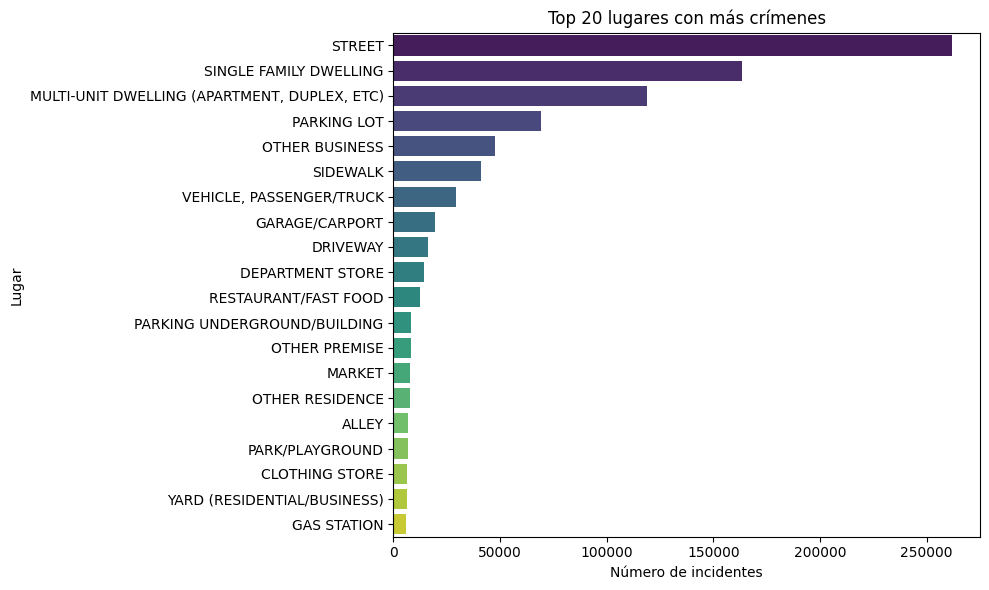

In [9]:
# Obtener los 20 lugares más frecuentes
top_20 = df['Premis Desc'].value_counts().head(20)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")

plt.title("Top 20 lugares con más crímenes")
plt.xlabel("Número de incidentes")
plt.ylabel("Lugar")
plt.tight_layout()
plt.show()
# Esto no lo pide pero es bueno saber

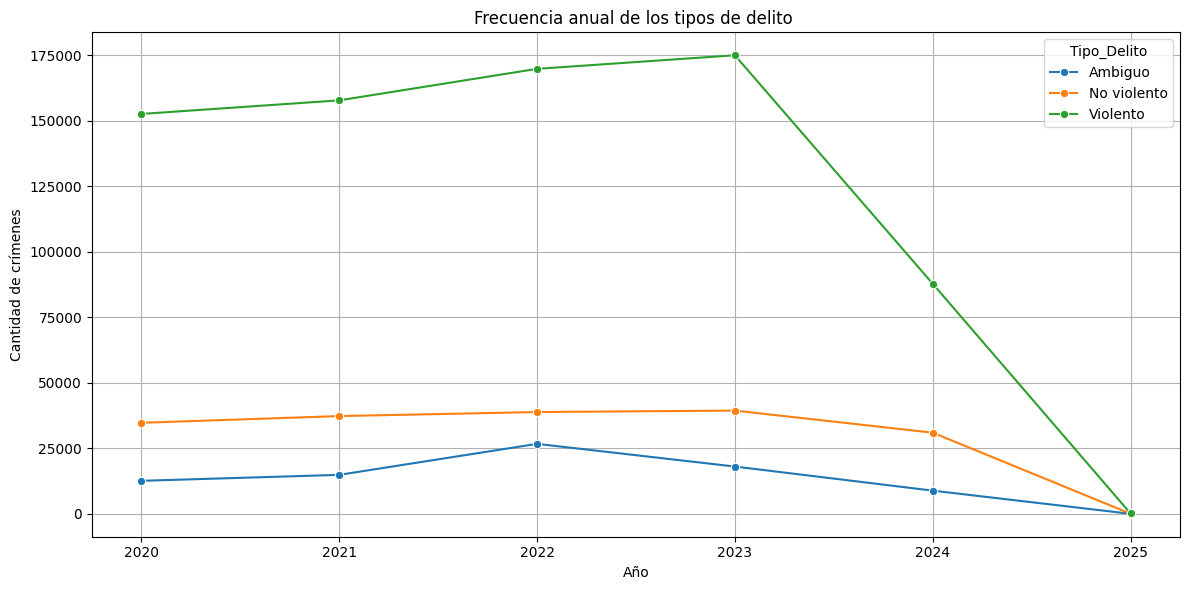

In [10]:
# Crear una columna con el año de ocurrencia del crimen
df['Año'] = df['DATE OCC'].dt.year

# Agrupar por año y tipo de delito, y contar la cantidad de ocurrencias
frecuencia_anual = df.groupby(['Año', 'Tipo_Delito']).size().reset_index(name='Frecuencia')

# Mostrar el resultado
top_delitos = df['Tipo_Delito'].value_counts().index

# Filtramos solo esos delitos
frecuencia_top = frecuencia_anual[frecuencia_anual['Tipo_Delito'].isin(top_delitos)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=frecuencia_top, x='Año', y='Frecuencia', hue='Tipo_Delito', marker='o')
plt.title("Frecuencia anual de los tipos de delito ")
plt.xlabel("Año")
plt.ylabel("Cantidad de crímenes")
plt.grid(True)
plt.tight_layout()
plt.show()

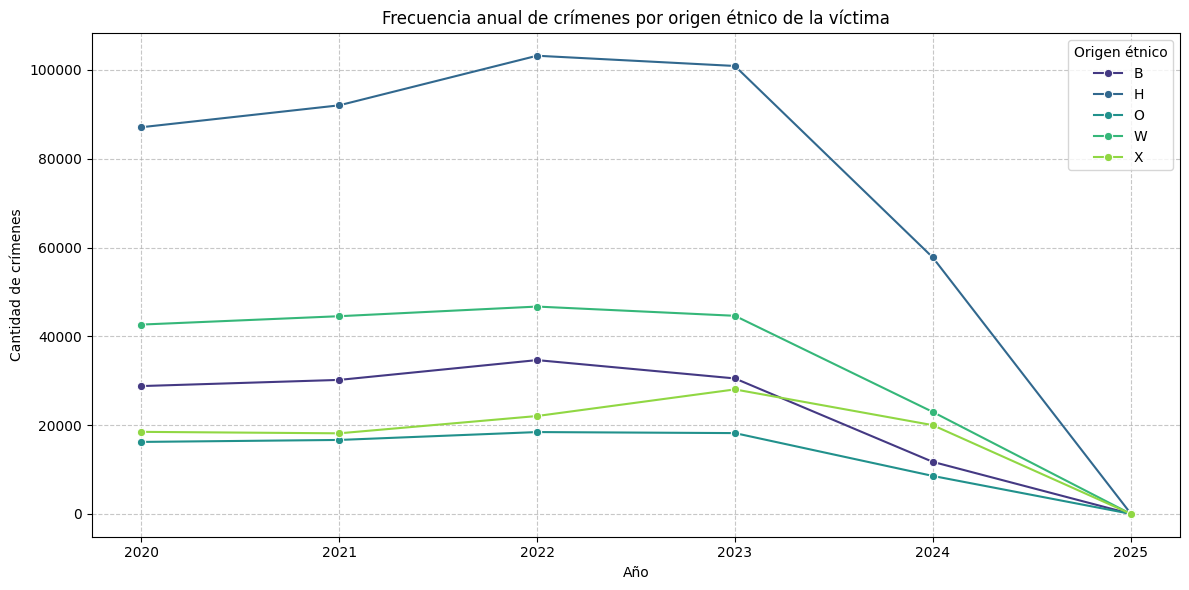

In [11]:
# Crear una columna con el año de ocurrencia del crimen
df['Año'] = df['DATE OCC'].dt.year

# Agrupar por año y origen étnico de la víctima (Vict Descent), y contar ocurrencias
frecuencia_anual = df.groupby(['Año', 'Vict Descent']).size().reset_index(name='Frecuencia')

# Mostrar el resultado
# Seleccionamos los 5 orígenes étnicos más comunes para mejor visualización
top_descents = df['Vict Descent'].value_counts().head(5).index

# Filtramos solo esos grupos
frecuencia_top = frecuencia_anual[frecuencia_anual['Vict Descent'].isin(top_descents)]

# Configurar el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=frecuencia_top, 
    x='Año', 
    y='Frecuencia', 
    hue='Vict Descent',  # Usamos Vict Descent para diferenciar líneas
    marker='o',
    palette='viridis'  # Mejor contraste de colores
)

plt.title("Frecuencia anual de crímenes por origen étnico de la víctima")
plt.xlabel("Año")
plt.ylabel("Cantidad de crímenes")
plt.legend(title='Origen étnico')  # Leyenda más descriptiva
plt.grid(True, linestyle='--', alpha=0.7)  # Grid más suave
plt.tight_layout()
plt.show()

In [12]:
# Cargar vecindarios desde la API
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [13]:
# Crear geometría a partir de LAT y LON
df['geometry'] = df.apply(lambda row: Point(row['LON'], row['LAT']), axis=1)

# Convertir df a GeoDataFrame
df = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")



In [14]:
neighborhoods = neighborhoods.to_crs(df.crs)
df= gpd.sjoin(df, neighborhoods, how="left", predicate="within")

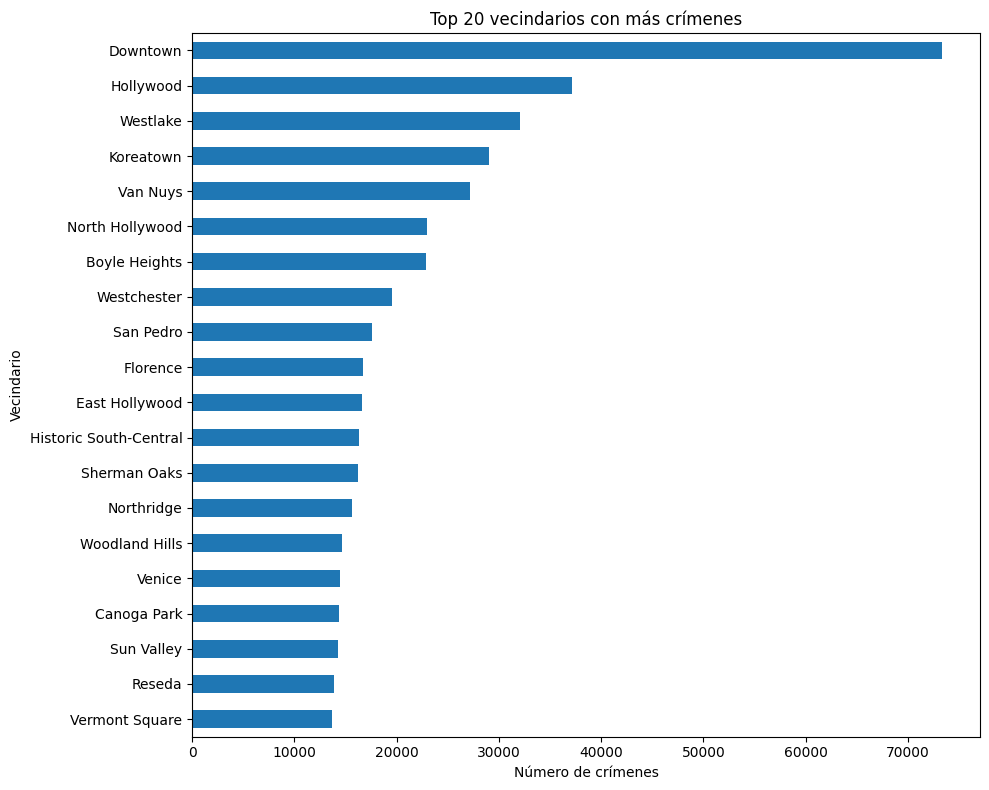

In [15]:
df['name'].value_counts().head(20).plot(kind='barh', figsize=(10, 8))
plt.xlabel('Número de crímenes')
plt.ylabel('Vecindario')
plt.title('Top 20 vecindarios con más crímenes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [16]:
# % de crimen por vecindario
crime_by_neighborhood = (df.groupby('name').size())/len(df)

# Mostrar los resultados
print(crime_by_neighborhood)

name
Adams-Normandie           0.003780
Arleta                    0.003952
Arlington Heights         0.005207
Atwater Village           0.002484
Baldwin Hills/Crenshaw    0.009940
                            ...   
Westwood                  0.006733
Wilmington                0.013019
Windsor Square            0.001557
Winnetka                  0.008976
Woodland Hills            0.014507
Length: 114, dtype: float64


In [17]:
premisas_riesgo = df[df['Tipo_Delito'] == 'Violento']['Premis Desc'].value_counts().head(3)
premisas_riesgo

Premis Desc
STREET                                          158003
SINGLE FAMILY DWELLING                          116212
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)     92055
Name: count, dtype: int64

In [18]:
edad_promedio = df.groupby('Vict Sex')['Vict Age'].mean()
conteo_sexo = df['Vict Sex'].value_counts(normalize=True)

In [19]:
df = df.drop(columns=["OBJECTID", "index_right"])
# Renombrar columna
df = df.rename(columns={"name": "Vecindario"})

# Imputar valores nulos con la moda
moda_vecindario = df["Vecindario"].mode()[0]
df["Vecindario"] = df["Vecindario"].fillna(moda_vecindario)


In [20]:
agrupado = df.groupby(["Vecindario", "Año", "Tipo_Delito", "Vict Descent"]).size().reset_index(name="Total_Crimenes")
agrupado

,Vecindario,Año,Tipo_Delito,Vict Descent,Total_Crimenes
0,Adams-Normandie,2020,Ambiguo,A,2
1,Adams-Normandie,2020,Ambiguo,B,9
2,Adams-Normandie,2020,Ambiguo,C,2
3,Adams-Normandie,2020,Ambiguo,H,24
4,Adams-Normandie,2020,Ambiguo,O,3
...,...,...,...,...,...
14256,Woodland Hills,2024,Violento,U,2
14257,Woodland Hills,2024,Violento,V,4
14258,Woodland Hills,2024,Violento,W,749
14259,Woodland Hills,2024,Violento,X,75


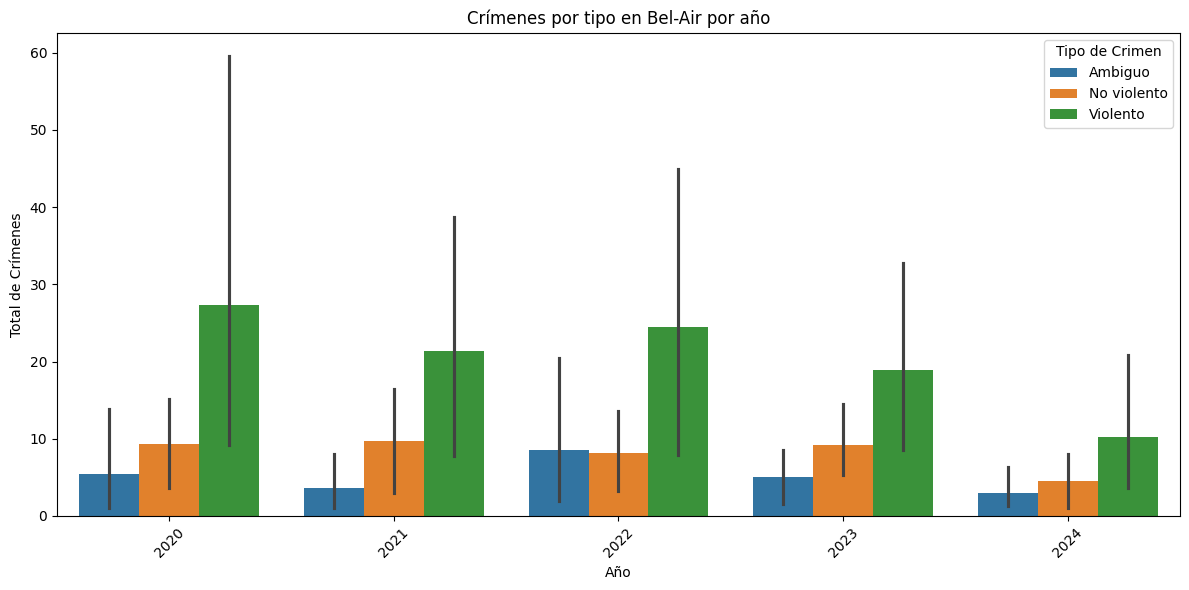

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtra un vecindario específico (ejemplo: 'Hollywood')
vecindario_objetivo = "Bel-Air"
df_filtrado = agrupado[agrupado["Vecindario"] == vecindario_objetivo]

# Crear gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_filtrado,
    x="Año",
    y="Total_Crimenes",
    hue="Tipo_Delito"
)

plt.title(f"Crímenes por tipo en {vecindario_objetivo} por año")
plt.ylabel("Total de Crímenes")
plt.xlabel("Año")
plt.legend(title="Tipo de Crimen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
import geopandas as gpd

# Cargar los vecindarios desde la API
vecindarios = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

# Asegurar que el sistema de referencia de coordenadas sea WGS84
vecindarios = vecindarios.to_crs(epsg=4326)

# Calcular el área en millas cuadradas
vecindarios["area_mi2"] = vecindarios.geometry.to_crs(epsg=3857).area * 3.861e-7  # Convertir de metros cuadrados a millas cuadradas


In [23]:
# Contar delitos por vecindario
delitos_por_vecindario = df.groupby("Vecindario").size().reset_index(name="total_delitos")

# Unir con el DataFrame de vecindarios para obtener el área
delitos_con_area = delitos_por_vecindario.merge(vecindarios[["name", "area_mi2"]], left_on="Vecindario", right_on="name", how="left")

# Calcular la densidad de delitos por milla cuadrada
delitos_con_area["delitos_por_milla2"] = delitos_con_area["total_delitos"] / delitos_con_area["area_mi2"]
delitos_con_area.sort_values(by="delitos_por_milla2", ascending=False).head(20)  # de mayor a menor


,Vecindario,total_delitos,name,area_mi2,delitos_por_milla2
23,Downtown,84945,Downtown,3.036235,27977.087660
100,Vermont Square,13720,Vermont Square,0.648190,21166.646572
108,Westlake,32073,Westlake,1.677809,19116.002458
52,Koreatown,28990,Koreatown,2.131950,13597.878266
25,East Hollywood,16588,East Hollywood,1.610343,10300.911416
51,Jefferson Park,5512,Jefferson Park,0.657059,8388.900302
20,Chinatown,4527,Chinatown,0.584821,7740.833859
37,Green Meadows,13008,Green Meadows,1.785572,7285.061102
0,Adams-Normandie,3808,Adams-Normandie,0.540433,7046.199467
99,Vermont Knolls,9052,Vermont Knolls,1.551599,5833.983155


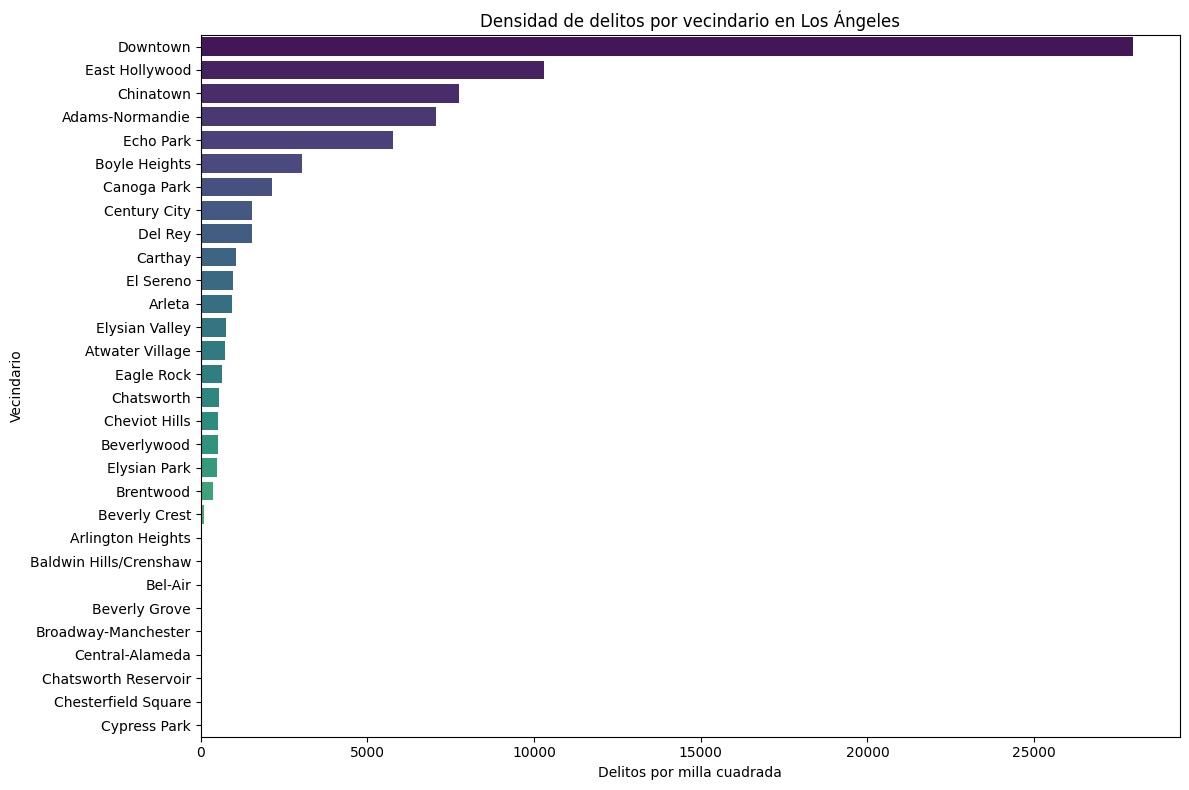

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar por densidad de delitos
delitos_con_area = delitos_con_area.head(30).sort_values("delitos_por_milla2", ascending=False)

# Crear el gráfico
plt.figure(figsize=(12, 8))
sns.barplot(data=delitos_con_area, x="delitos_por_milla2", y="Vecindario", palette="viridis")
plt.xlabel("Delitos por milla cuadrada")
plt.ylabel("Vecindario")
plt.title("Densidad de delitos por vecindario en Los Ángeles")
plt.tight_layout()
plt.show()


In [25]:
###########################################################

In [26]:
# Proyectar a un sistema de coordenadas adecuado para cálculo de áreas
vecindarios = vecindarios.to_crs(epsg=3857)

# Calcular el área en metros cuadrados
vecindarios["area_m2"] = vecindarios["geometry"].area

# Convertir el área a millas cuadradas (1 milla cuadrada = 2.59e+6 m²)
vecindarios["area_millas2"] = vecindarios["area_m2"] / 2.59e+6

# Volver a proyectar a WGS84 para visualización
vecindarios = vecindarios.to_crs(epsg=4326)


In [27]:
# Contar delitos por vecindario
delitos_por_vecindario = df.groupby("Vecindario").size().reset_index(name="total_delitos")


In [28]:
# Unir los datos
vecindarios = vecindarios.merge(delitos_por_vecindario, left_on="name", right_on="Vecindario", how="left")

# Rellenar valores nulos con 0
vecindarios["total_delitos"] = vecindarios["total_delitos"].fillna(0)
vecindarios["delitos_por_milla2"] = vecindarios["total_delitos"] / vecindarios["area_millas2"]

In [29]:
vecindarios["delitos_por_milla2"] = vecindarios["total_delitos"] / vecindarios["area_millas2"]


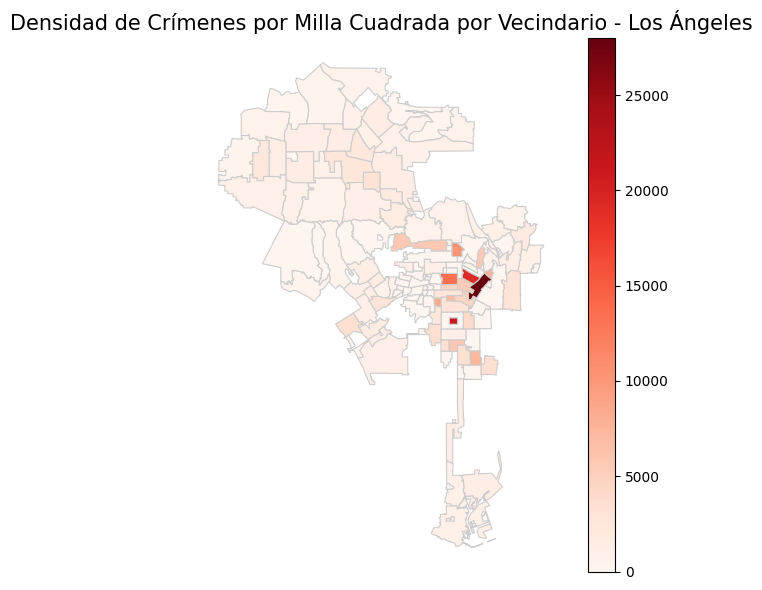

In [30]:
import matplotlib.pyplot as plt

# Crear el mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
vecindarios.plot(column='delitos_por_milla2', 
                 cmap='Reds', 
                 linewidth=0.8, 
                 edgecolor='0.8', 
                 legend=True, 
                 ax=ax)

ax.set_title('Densidad de Crímenes por Milla Cuadrada por Vecindario - Los Ángeles', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()


In [31]:
delitos_por_vecindario.sort_values("total_delitos", ascending=False)
#delitos_por_vecindario.head(50).sort_values("total_delitos", ascending=False)


,Vecindario,total_delitos
23,Downtown,84945
47,Hollywood,37179
108,Westlake,32073
52,Koreatown,28990
97,Van Nuys,27202
...,...,...
29,Elysian Valley,1061
82,Sepulveda Basin,1038
8,Beverlywood,800
40,Hansen Dam,319
